In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

Latest date is 2017-08-23 00:00:00
Query date is 2016-08-23 00:00:00


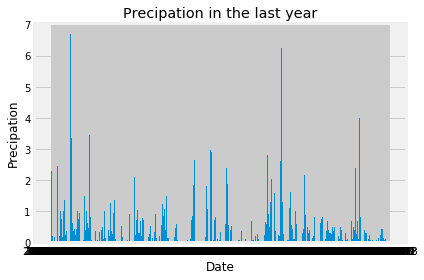

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
#query and get last date as first date from descending order list
date_result = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#convert to string and remove special characters
latest_date = str(date_result).strip("')''(','")

#convert latest date to datetime format
latest_date= dt.datetime.strptime(latest_date, "%Y-%m-%d")
print(f"Latest date is {latest_date}")

# Perform a query to retrieve the data and precipitation scores
#identify start date for query from 12 months (365 days) prior
query_date = latest_date - dt.timedelta(days=365)
print(f"Query date is {query_date}")

#create query statement for all dates and precipation totals within last year
statement = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(statement, session.bind)
df = df.set_index("date")

# Sort the dataframe by date
df = df.sort_index()

#drop na values
df = df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
#groupby date to get accumulated precipation for each date
precip = df.groupby("date")
precip_df = pd.DataFrame()
precip_df["Precipation"] = precip["prcp"].sum()
precip_df = precip_df.sort_index()

#plot date with matplotlib
plt.bar(df.index, df["prcp"])
plt.xlabel("Date")
plt.ylabel("Precipation")
plt.title("Precipation in the last year")
plt.grid(b=True, which='major', axis='y')
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
unique_stations = session.query(Measurement).group_by(Measurement.station).count()
print(F"Total number of unique stations is {unique_stations}")

Total number of unique stations is 9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# lowest temp

min_temp = session.query(func.min(Measurement.tobs)).all()
max_temp = session.query(func.max(Measurement.tobs)).all()

#most active station
most_active = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()

avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active[0]).all()

print(f"Lowest temperature is {min_temp}")
print(f"Highest temperature is {max_temp}")
print(f"Most active station is {most_active[0]}")
print(f"Avg temp at {most_active[0]} is {avg_temp}")

Lowest temperature is [(53.0,)]
Highest temperature is [(87.0,)]
Most active station is USC00519281
Avg temp at USC00519281 is [(71.66378066378067,)]


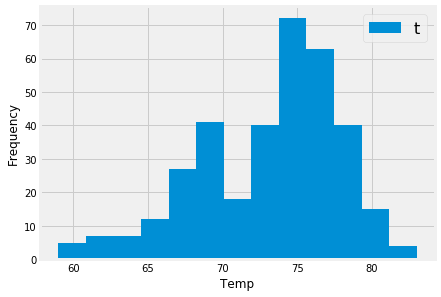

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

session.query(Measurement.tobs).filter(Measurement.station == most_active[0]).filter(Measurement.date >= query_date)
statement = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == most_active[0]).filter(Measurement.date >= query_date).statement
df = pd.read_sql_query(statement, session.bind)

plt.hist(df["tobs"], bins="auto")
plt.legend(labels="tobs", loc="best",prop={"size":16})
plt.tight_layout()
plt.xlabel("Temp")
plt.ylabel("Frequency")
plt.show()

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# enter manual trip dates
trip_start = "2018-01-05"
trip_end = "2018-01-19"

#calculate dates from 365 days prior and convert to appropriate format
query_start = (dt.datetime.strptime(trip_start, "%Y-%m-%d") - dt.timedelta(days = 365)).strftime('%Y-%m-%d')
query_end = (dt.datetime.strptime(trip_end, "%Y-%m-%d") - dt.timedelta(days = 365)).strftime('%Y-%m-%d')

#call calc_temps function
print(calc_temps(query_start, query_end))

[(60.0, 69.67391304347827, 81.0)]


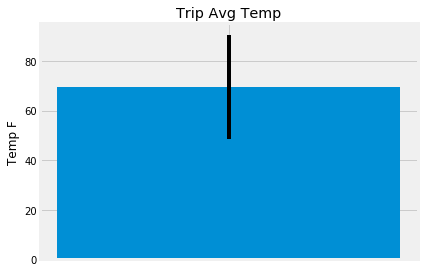

In [85]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temps = calc_temps(query_start, query_end)
t_min = temps[0][0]
t_avg = temps[0][1]
t_max = temps[0][2]
plt.bar(" ", t_avg, width=0.8, yerr=t_max - t_min)
plt.ylabel("Temp F")
plt.title("Trip Avg Temp")
plt.grid(b=True, which='major', axis='y')
plt.tight_layout()
plt.show()

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


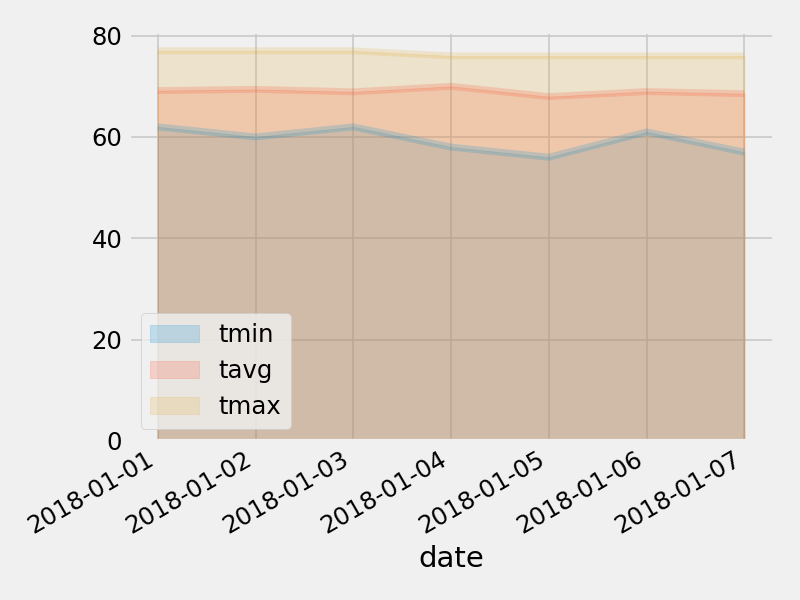

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
